In [1]:
import numpy as np
from astropy.utils.data import download_file
from spectral_cube import SpectralCube

In [2]:
import pylab as pl
# set so that these display properly on black backgrounds
pl.rcParams['figure.facecolor']='w'

In [3]:
import radio_beam

In [4]:
from astropy import units as u

In [5]:
filename = download_file('ftp://ftp.cv.nrao.edu/NRAO-staff/rloomis/MAPS/HD_163296/images/CO/0.15arcsec/HD_163296_CO_220GHz.0.15arcsec.JvMcorr.image.pbcor.fits', cache=True)

In [6]:
cube = SpectralCube.read(filename, use_dask=True)

In [7]:
cube

DaskSpectralCube with shape=(127, 2048, 2048) and unit=Jy / beam and chunk size (127, 512, 512):
 n_x:   2048  type_x: RA---SIN  unit_x: deg    range:   269.082528 deg:  269.094790 deg
 n_y:   2048  type_y: DEC--SIN  unit_y: deg    range:   -21.961977 deg:  -21.950605 deg
 n_s:    127  type_s: FREQ      unit_s: Hz     range: 230523958206.200 Hz:230543336804.442 Hz

In [8]:
mx = cube.max(axis=0)

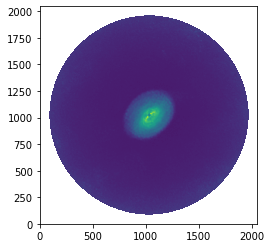

In [9]:
pl.imshow(mx.value, origin='lower')

In [10]:
import regions

In [11]:
center = regions.PixCoord(1024, 1024)
ellipse = regions.EllipsePixelRegion(center, width=550, height=400, angle=45*u.deg)

<AxesSubplot:>

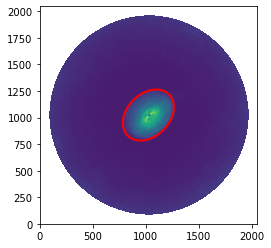

In [12]:
ax = pl.gca()
ax.imshow(mx.value, origin='lower')
ellipse.plot(ax=ax, facecolor='none', edgecolor='red', lw=2)

In [13]:
cutout = cube.subcube_from_regions([ellipse])
cutout

DaskSpectralCube with shape=(127, 481, 481) and unit=Jy / beam and chunk size (127, 241, 241):
 n_x:    481  type_x: RA---SIN  unit_x: deg    range:   269.087219 deg:  269.090094 deg
 n_y:    481  type_y: DEC--SIN  unit_y: deg    range:   -21.957622 deg:  -21.954955 deg
 n_s:    127  type_s: FREQ      unit_s: Hz     range: 230523958206.200 Hz:230543336804.442 Hz

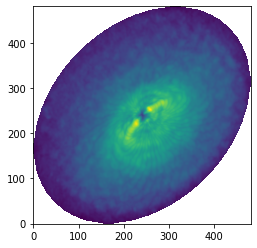

In [14]:
pl.imshow(cutout.max(axis=0).value, origin='lower')

In [15]:
import pvextractor

In [18]:
path = pvextractor.Path([(0,0), (481,481)], width=20)

In [23]:
pv = pvextractor.extract_pv_slice(cutout.with_spectral_unit(u.km/u.s, velocity_convention='radio'), path)

In [24]:
from astropy import wcs

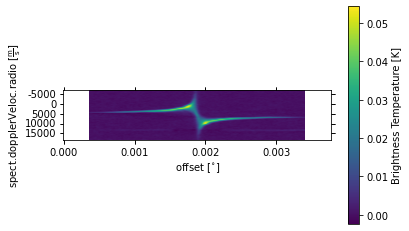

In [25]:
ax = pl.subplot(111, projection=wcs.WCS(pv.header))
im = ax.imshow(pv.data)
cb = pl.colorbar(mappable=im)
cb.set_label("Brightness Temperature [K]")

# Second approach

In [26]:
new_cube_wcs = cutout.wcs.celestial.copy()

In [28]:
new_cube_wcs.wcs.crota = [45,0]
header = new_cube_wcs.to_header()
header['NAXIS1'] = 400
header['NAXIS2'] = 400

In [31]:
reproj = cutout.reproject(header)

KeyError: "Keyword 'NAXIS' not found."

In [30]:
cutout.reproject?

Signature: cutout.reproject(header, order='bilinear', use_memmap=False, filled=True)
Docstring:
Spatially reproject the cube into a new header.  Fills the data with
the cube's ``fill_value`` to replace bad values before reprojection.

If you want to reproject a cube both spatially and spectrally, you need
to use `spectral_interpolate` as well.

.. warning::
    The current implementation of ``reproject`` requires that the whole
    cube be loaded into memory.  Issue #506 notes that this is a
    problem, and it is on our to-do list to fix.

Parameters
----------
header : `astropy.io.fits.Header`
    A header specifying a cube in valid WCS
order : int or str, optional
    The order of the interpolation (if ``mode`` is set to
    ``'interpolation'``). This can be either one of the following
    strings:

        * 'nearest-neighbor'
        * 'bilinear'
        * 'biquadratic'
        * 'bicubic'

    or an integer. A value of ``0`` indicates nearest neighbor
    interpolation.
use_memma